# Prepare Environment

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-68b49d17-5b7a-b859-2583-571e8615da79)


In [2]:
import sys
print( f"Python {sys.version}\n" )

import os

import math

import numpy as np
print( f"NumPy {np.__version__}\n" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )




# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]

NumPy 1.25.2

Pandas 2.0.3

Matplotlib 3.7.2

TensorFlow 2.10.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Rescaling
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import History , ModelCheckpoint
from keras import models

DenseNet-201 model architecture requires the image to be of size (224, 224)

In [4]:
#Resize

BATCH_SIZE = 8

IMG_HEIGHT = 224
IMG_WIDTH = 224

epochs = 200

# Prepearing The Images

In [5]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np.random.seed(1234)
tf.random.set_seed(5678)

define the paths of train and test data

In [6]:
base_dir = 'dataset'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Loading The Images

In [7]:
train_dataset = image_dataset_from_directory(train_dir,
                                             validation_split=0.1,
                                             subset="training",
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int',
                                             color_mode='rgb',
                                             image_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )



class_names = train_dataset.class_names
print(class_names)

Found 640 files belonging to 4 classes.
Using 576 files for training.
['caribou', 'deer', 'elk', 'moose']


In [8]:
validation_dataset = image_dataset_from_directory(train_dir,
                                             validation_split=0.1,
                                             subset="validation",
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int',
                                             color_mode='rgb',
                                             image_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

class_names = validation_dataset.class_names
print(class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [9]:
test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             label_mode='int',
                                             color_mode='rgb',
                                             image_size=(IMG_HEIGHT, IMG_WIDTH)
                                             )

class_names = test_dataset.class_names
print(class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


# Visualize The Images

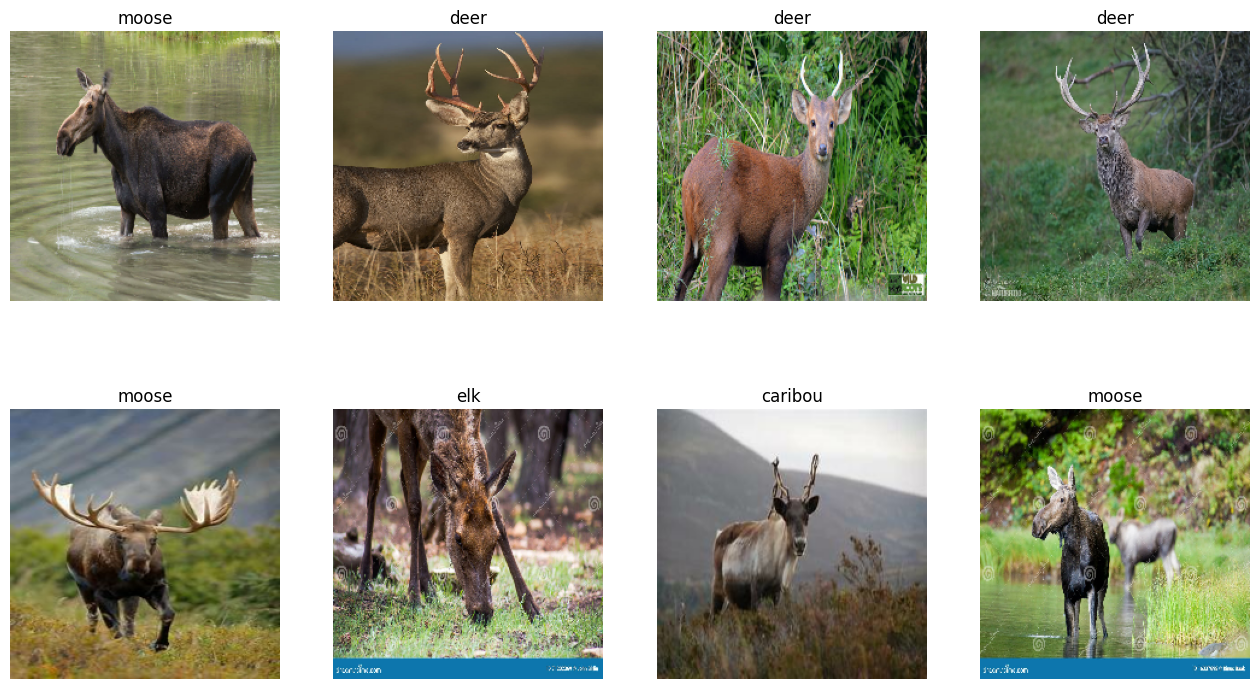

In [10]:
plt.figure(figsize=(16,9))
for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis('off')

# Image Augmentation

In [11]:
data_augmentation = Sequential(
    [
        RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), mode='horizontal', name='rand_flip'),
        RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
        RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
        RandomZoom(height_factor=0.1,fill_mode='nearest'),
        RandomBrightness(0.2),
        Rescaling(1./255)
    ]
    , name='Argumentation'
)

Visualize Original And Augmented Images

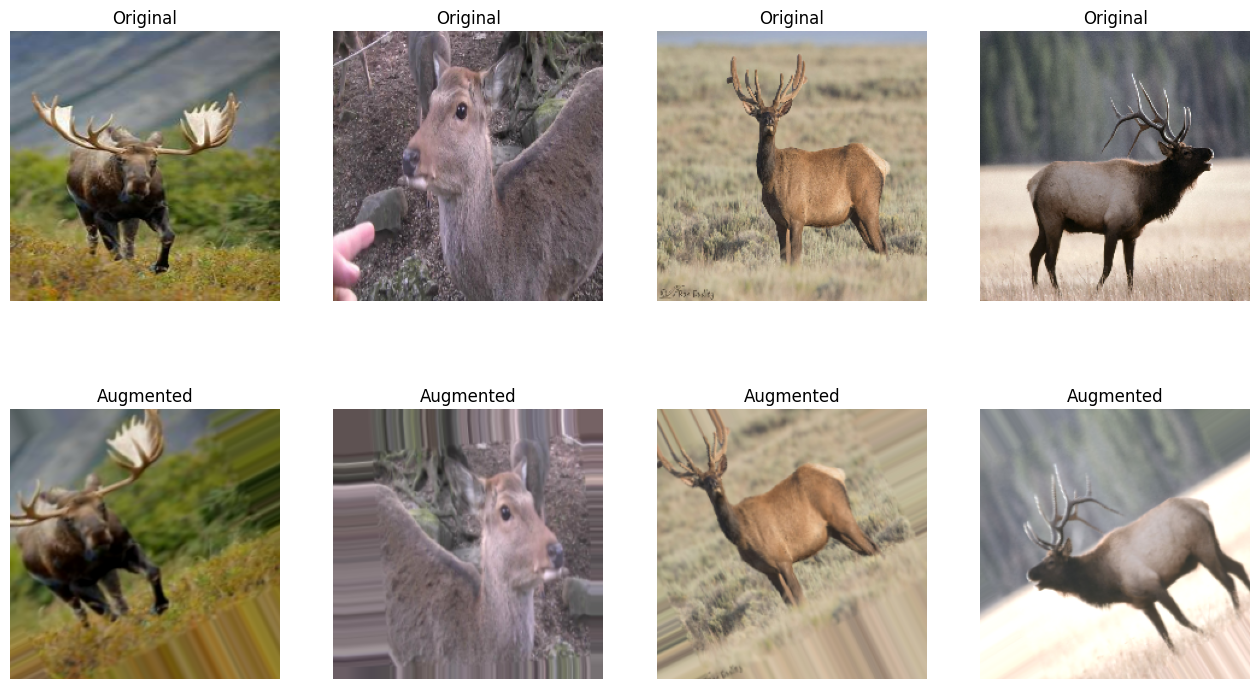

In [12]:
plt.figure(figsize=(16,9))
for images, labels in train_dataset.take(1):
    argImg = data_augmentation(images)
    for i in range(int(BATCH_SIZE/2)):
        
        plt.subplot(2,4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2,4, i + 1 + int(BATCH_SIZE/2))
        plt.imshow(argImg[i])
        plt.title("Augmented")
        plt.axis("off")

Improvements in Dataset

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Model

In [14]:
base_densenet_model = DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), 
                                  weights="imagenet", 
                                  include_top=False)

base_densenet_model.trainable = False
base_densenet_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [15]:
for layer in base_densenet_model.layers:
    # if layer.name in ['conv5_block3_3_conv']:
    #     layer.trainable = True
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
        
for i,layer in enumerate(base_densenet_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = zero_padding2d , trainable = False
Layer 2: name = conv1/conv , trainable = False
Layer 3: name = conv1/bn , trainable = True
Layer 4: name = conv1/relu , trainable = False
Layer 5: name = zero_padding2d_1 , trainable = False
Layer 6: name = pool1 , trainable = False
Layer 7: name = conv2_block1_0_bn , trainable = True
Layer 8: name = conv2_block1_0_relu , trainable = False
Layer 9: name = conv2_block1_1_conv , trainable = False
Layer 10: name = conv2_block1_1_bn , trainable = True
Layer 11: name = conv2_block1_1_relu , trainable = False
Layer 12: name = conv2_block1_2_conv , trainable = False
Layer 13: name = conv2_block1_concat , trainable = False
Layer 14: name = conv2_block2_0_bn , trainable = True
Layer 15: name = conv2_block2_0_relu , trainable = False
Layer 16: name = conv2_block2_1_conv , trainable = False
Layer 17: name = conv2_block2_1_bn , trainable = True
Layer 18: name = conv2_block2_1_relu , trainable = False
Lay

In [16]:
# custom_densenet_model = Sequential([
#     base_densenet_model,
#     GlobalAveragePooling2D(),
#     Dropout(0.2),
#     Dense(units=4, activation='softmax'),
#     ],name = "custom_densenet_model")

base_model_output = base_densenet_model.output

# model 1
# x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)

# model 2
# x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(256, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(128, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(64, activation="relu")(x)

# model 3
x = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
x = tf.keras.layers.Dropout(0.6)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)


new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
custom_densenet_model = tf.keras.models.Model(inputs=base_densenet_model.inputs, outputs=new_outputs)
custom_densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [17]:
for i,layer in enumerate(custom_densenet_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_1 , trainable = False
Layer 1: name = zero_padding2d , trainable = False
Layer 2: name = conv1/conv , trainable = False
Layer 3: name = conv1/bn , trainable = True
Layer 4: name = conv1/relu , trainable = False
Layer 5: name = zero_padding2d_1 , trainable = False
Layer 6: name = pool1 , trainable = False
Layer 7: name = conv2_block1_0_bn , trainable = True
Layer 8: name = conv2_block1_0_relu , trainable = False
Layer 9: name = conv2_block1_1_conv , trainable = False
Layer 10: name = conv2_block1_1_bn , trainable = True
Layer 11: name = conv2_block1_1_relu , trainable = False
Layer 12: name = conv2_block1_2_conv , trainable = False
Layer 13: name = conv2_block1_concat , trainable = False
Layer 14: name = conv2_block2_0_bn , trainable = True
Layer 15: name = conv2_block2_0_relu , trainable = False
Layer 16: name = conv2_block2_1_conv , trainable = False
Layer 17: name = conv2_block2_1_bn , trainable = True
Layer 18: name = conv2_block2_1_relu , trainable = False
Lay

In [18]:
custom_densenet_model.compile(optimizer=Adam(learning_rate=0.001*3),
                            loss=tf.keras.losses.sparse_categorical_crossentropy,
                            metrics=['accuracy']
                            )

# Fit model

In [19]:
# Early stopping to monitor the validation loss and avoid overfitting
early = EarlyStopping(#monitor="val_loss",
                      monitor='val_accuracy',
                      patience=math.floor(epochs*0.3))

# ReduceLROnPlateau to stabilize the training process of the model
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

# save the model in the current directory as the best validation accuracy is achieved
modelcheck = ModelCheckpoint('model_3.hdf5',
                             #monitor='val_accuracy',
                             monitor="val_loss",
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [20]:
model_history = custom_densenet_model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs = epochs,
    callbacks = [modelcheck, learning_rate_reduction, early],
    verbose = 1
)

Epoch 1/200
72/72 [==============================] - ETA: 0s - loss: 1.4840 - accuracy: 0.3333
Epoch 1: val_loss improved from inf to 2.22887, saving model to model_3.hdf5
72/72 [==============================] - 25s 163ms/step - loss: 1.4840 - accuracy: 0.3333 - val_loss: 2.2289 - val_accuracy: 0.4219 - lr: 0.0030
Epoch 2/200
72/72 [==============================] - ETA: 0s - loss: 1.0041 - accuracy: 0.5660
Epoch 2: val_loss improved from 2.22887 to 1.50728, saving model to model_3.hdf5
72/72 [==============================] - 10s 138ms/step - loss: 1.0041 - accuracy: 0.5660 - val_loss: 1.5073 - val_accuracy: 0.4531 - lr: 0.0030
Epoch 3/200
72/72 [==============================] - ETA: 0s - loss: 0.8017 - accuracy: 0.6892
Epoch 3: val_loss improved from 1.50728 to 1.10884, saving model to model_3.hdf5
72/72 [==============================] - 10s 139ms/step - loss: 0.8017 - accuracy: 0.6892 - val_loss: 1.1088 - val_accuracy: 0.6562 - lr: 0.0030
Epoch 4/200
72/72 [======================

In [21]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

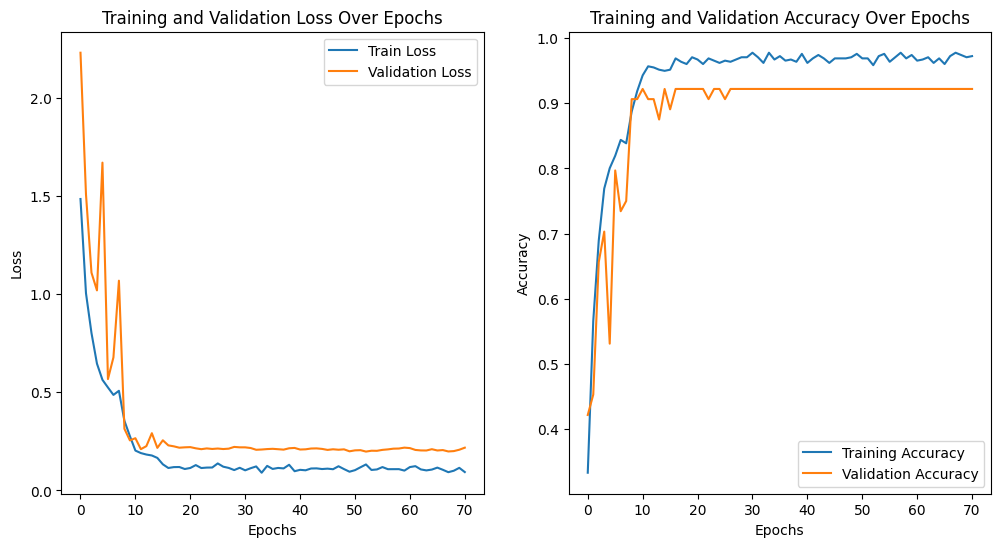

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [23]:
test_result = custom_densenet_model.evaluate(test_dataset)
print(f'{custom_densenet_model.metrics_names}: {test_result}')

20/20 [==============================] - 1s 43ms/step - loss: 0.2319 - accuracy: 0.9312
['loss', 'accuracy']: [0.23185917735099792, 0.9312499761581421]


In [24]:
from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam

In [25]:
last_conv_layer_name = "conv5_block32_2_conv"

In [26]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(IMG_HEIGHT,IMG_WIDTH))
heatmap = make_gradcam_heatmap(img, custom_densenet_model, last_conv_layer_name)

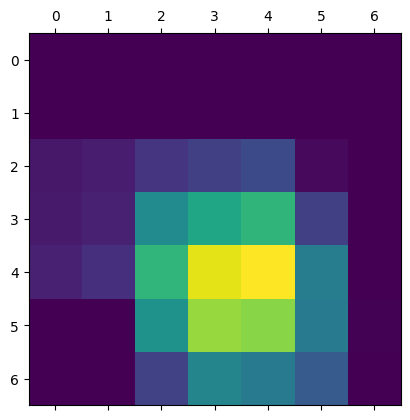

In [27]:
plt.matshow(heatmap)
plt.show()

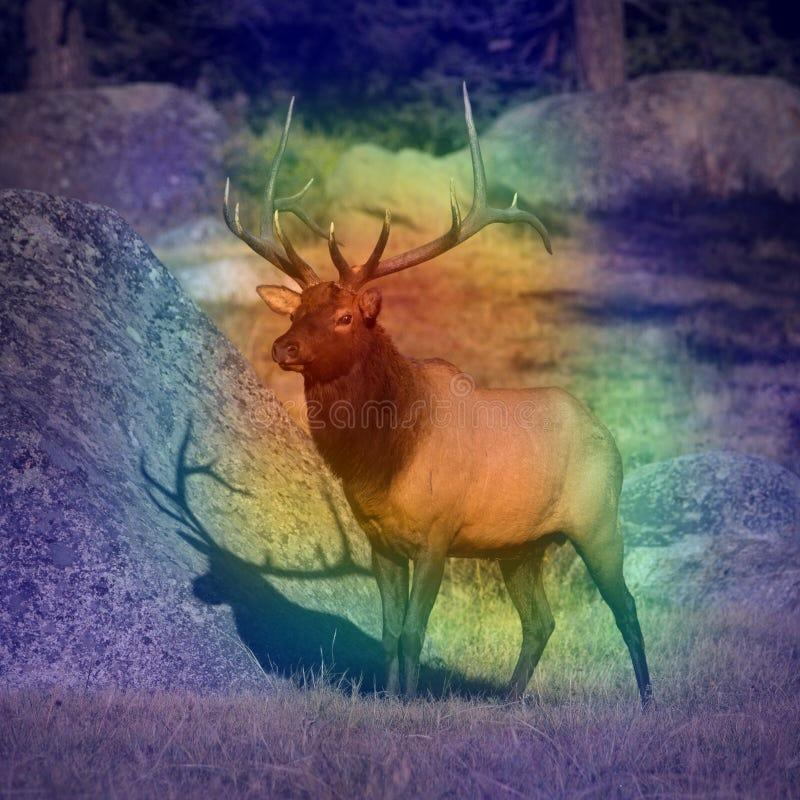

In [28]:
grad_cam_img_path = 'dataset/train/elk/EDM75.jpg'
img = get_img_array(grad_cam_img_path,size=(IMG_HEIGHT,IMG_WIDTH))
heatmap = make_gradcam_heatmap(img, custom_densenet_model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

In [29]:
model_path = "model_3.hdf5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

20/20 [==============================] - 2s 43ms/step - loss: 0.2344 - accuracy: 0.9312
['loss', 'accuracy']: [0.23439064621925354, 0.9312499761581421]


1/1 [==============================] - 2s 2s/step


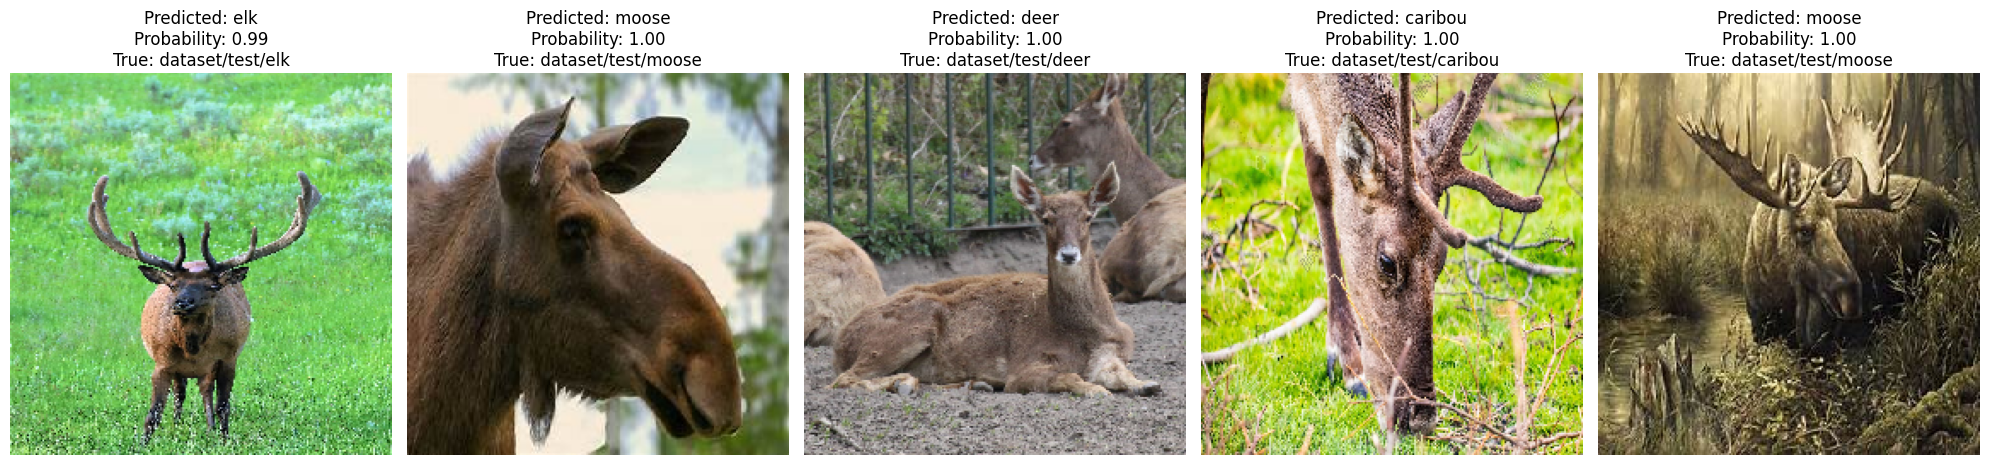

In [36]:
from keras import models
from show_predicted_img import show_predicted_img  

# Load your trained model
model = models.load_model(model_path)
# Directory where your test images are located, structured with subdirectories for each class
#test_images_directory = 'dataset/test/'
test_images_directory = 'dataset/test/'
class_name = {0:'caribou',1:'deer',2:'elk',3:'moose'}
show_predicted_img(model,test_images_directory,class_name)